# This takes an image from the NEOWISE SAA database and does the following to create a data file of images with labels:

- takes a portion of it into a smaller image (for processing time)
- identifies bright spots in the smaller image and takes their coordinates
- uses those coordinates to isolate those bright spots into even smaller images
- TODO: saves those images, their coordinates in the original image, and their label (cosmic ray/not cosmic ray) into a file

## Imports

In [1]:
%matplotlib inline
# ^ necessary for in-line plots

import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

## Load image and visualize

In [2]:
# check images in images folder
!ls 'SAA_images'

saa_img1.png


In [3]:
# load image from folder
img = cv2.imread('SAA_images/saa_img1.png')

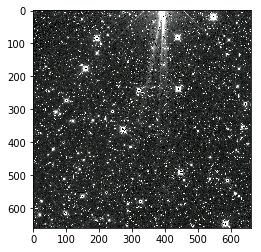

In [4]:
# using matplotlib imshow instead of cv2 b/c it can display inline
plt.imshow(img, cmap='gray');

In [5]:
start_x = 0
start_y = 0
img_size = 50
img_sm_og = img[start_y:(start_y+img_size), start_x:(start_x+img_size)]

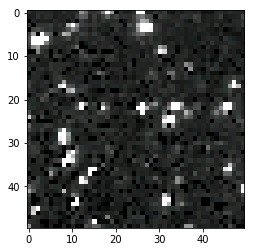

In [6]:
plt.imshow(img_sm_og, cmap='gray');

## Detect bright spots

https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/

^ this didn't actually work great. It did lead me to this documentation though:
https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html

In [7]:
#imports
import numpy as np
import cv2

(50, 50, 3)

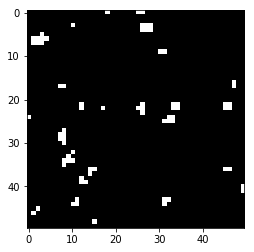

In [8]:
# apply light threshold to image
# this takes any pixel value >= 200 and sets it to 255 (white)

thresh = cv2.threshold(img_sm_og, 200, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh);
thresh.shape

(50, 50)

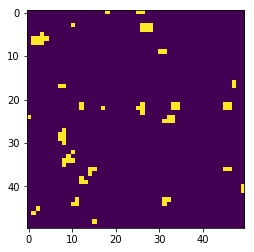

In [9]:
# Turning this into a gray image to find contours later
thresh_gray = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

plt.imshow(thresh_gray);
thresh_gray.shape # should only be 2D

In [69]:
# this isolates the bright spots in an image (gives you coords)
contours, hierarchy = cv2.findContours(thresh_gray, 1, 2)
cnt = contours[0] # indeces of one bright spot
print(cnt)
cnt.shape

[[[15 48]]]


(1, 1, 2)

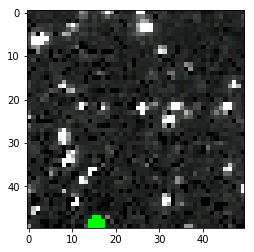

In [11]:
# RECTANGLE CHANGES THE ORIGINAL IMAGE, SO MAKE A COPY
rect_img = img_sm_og.copy()

# This draws a bounding box at the site of the bright spot
x, y, w, h = cv2.boundingRect(cnt)
cv2.rectangle(rect_img, (x,y), (x+w,y+h),(0,255,0),2)
plt.imshow(rect_img);

48 49
15 16
45 51
12 18


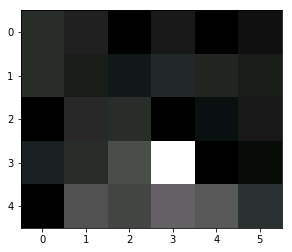

In [12]:
# We can get a portion of the image!! Woohoo!! Look at this test image:

#want a certain amount of pixels on either side of image
size = 6

ymax = y+h # this is for comparison's sake
xmax = x+w

row_mid = (y+y+h)/2
column_mid = (x+x+w)/2

row_begin = int(row_mid - (size/2))
row_end = int(row_mid + (size/2))

column_begin = int(column_mid - (size/2))
column_end = int(column_mid + (size/2))

temp = img_sm_og[row_begin:row_end, column_begin:column_end]

plt.imshow(temp);

print(y, ymax)
print(x, xmax)
print(row_begin, row_end)
print(column_begin, column_end)

## Plot detected bright spots

In [13]:
# general func for obtaining smaller img
def get_bright_spot(index, size, resize_img=False):
    if index < len(contours):
        cnt = contours[index]
        if len(cnt) > 1:
            cnt = cnt[0]

        x, y, w, h = cv2.boundingRect(cnt)
        row_mid = (y+y+h)/2
        column_mid = (x+x+w)/2

        row_begin = int(row_mid - (size/2))
        row_end = int(row_mid + (size/2))

        column_begin = int(column_mid - (size/2))
        column_end = int(column_mid + (size/2))
        
        if row_begin < 0:
            row_begin = 0
        
        if column_begin < 0:
            column_begin = 0

        img_temp = img_sm_og[row_begin:row_end, column_begin:column_end]
    
    else:
        img_temp = np.random.randint(10,size=(size,size))
        row_mid = 0
        column_mid = 0
        
    if resize_img:
        height = img_temp.shape[0]
        width = img_temp.shape[1]
        if height != size or width != size:
            img_temp = resize_image(img_temp, size)
        
    return img_temp, column_mid, row_mid

def resize_image(image, size):
    h, w = image.shape[0], image.shape[1]

    top = size - h
    bottom = 0
    left = size - w
    right = 0

    BLACK = [0,0,0]
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    return image

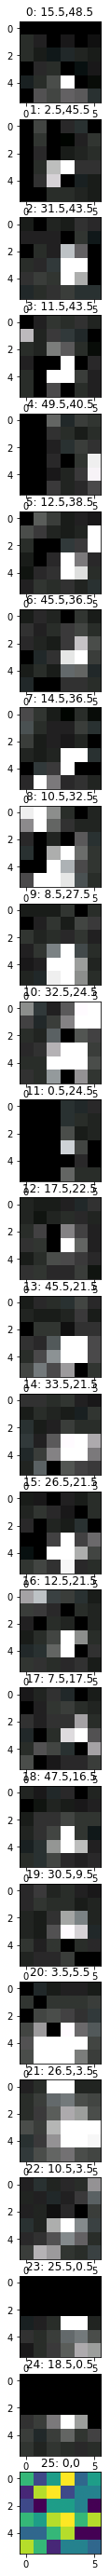

In [14]:
# Now to try to plot multiple bright spots

num_cnts = len(contours)
fig = plt.figure(figsize=(num_cnts*2, 2*num_cnts))

columns = 1
rows = int(num_cnts/columns)+1

for i in range(0, rows*columns):
    img_new, x, y = get_bright_spot(i,6,resize_img=True)
    ax = plt.subplot(rows,columns,i+1)
    ax.set_title('{}: {},{}'.format(i, x, y))
    ax.imshow(img_new)
    
plt.show()

# Save data (TODO)

## Create file

In [21]:
import os

path = "processed_images/"
name = "data"
file_name = "{}{}".format(path, name)

file = open(file_name, "w+") # w+ indicates appending to file, + means creating if it doesn't exist
type(img_new)
# want to save img, x and y coords in original image, and key for type of object
#file.write("img_num,x,y,label \n")
#file.close()

## Save detected bright spots
Append info to file

In [64]:
# note: need to make img_sm_og and contours in above cells

def save_bright_spot(image,img_num, x, y, label):
    cv2.imwrite(os.path.join(path, '{}.png'.format(img_num)), image)
    with open(file_name, 'a') as file:
        file.write('{},{},{},{}\n'.format(img_num,x,y,label))
    

In [67]:
for i in range(0,len(contours)):
    img_new, x, y = get_bright_spot(i,6,resize_img=True)
    save_bright_spot(img_new,i,x, y, 1)

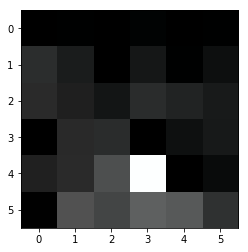

In [63]:
test = cv2.imread('processed_images/test.jpg', 1)
type(test)
plt.imshow(test)

## Open image from file

In [68]:
import pandas as pd

data = pd.read_csv(file_name, delimiter = ",", engine='python')
#data = open(name, 'r')
print(data)
data.shape

    img_num     x     y  label
0         0  15.5  48.5      1
1         1   2.5  45.5      1
2         2  31.5  43.5      1
3         3  11.5  43.5      1
4         4  49.5  40.5      1
5         5  12.5  38.5      1
6         6  45.5  36.5      1
7         7  14.5  36.5      1
8         8  10.5  32.5      1
9         9   8.5  27.5      1
10       10  32.5  24.5      1
11       11   0.5  24.5      1
12       12  17.5  22.5      1
13       13  45.5  21.5      1
14       14  33.5  21.5      1
15       15  26.5  21.5      1
16       16  12.5  21.5      1
17       17   7.5  17.5      1
18       18  47.5  16.5      1
19       19  30.5   9.5      1
20       20   3.5   5.5      1
21       21  26.5   3.5      1
22       22  10.5   3.5      1
23       23  25.5   0.5      1
24       24  18.5   0.5      1


(25, 4)